In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.
/Users/suhang/anaconda3/envs/keras/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Load Data

In [2]:
path = 'data/'
EMBEDDING_FILE=f'{path}glove.6B.50d.txt'
TRAIN_DATA_FILE=f'{path}train.csv'
TEST_DATA_FILE=f'{path}test.csv'
CLEAN_TRAIN_FILE=f'{path}clean_nltk2.csv'

In [3]:
embed_size = 50
max_features = 20000
maxlen = 100

In [4]:
train = pd.read_csv(TRAIN_DATA_FILE)
test = pd.read_csv(TEST_DATA_FILE)

In [5]:
clean_train = pd.read_csv(CLEAN_TRAIN_FILE, header=None, index_col=0)

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train.shape

(159571, 8)

In [8]:
clean_train.columns = ['clean_comment_text']
clean_train.head()

,clean_comment_text
0,
0,ExplanationWhy edit make username Hardcore Met...
1,D'aww ! He match background colour I'm seeming...
2,"Hey man , I'm really try edit war . It's guy c..."
3,""" MoreI cannot make real suggestions improveme..."
4,"You , sir , hero . Any chance remember page th..."


In [9]:
clean_train.shape

(312735, 1)

In [10]:
train['clean_comment_text'] = clean_train['clean_comment_text'][:159571]

In [11]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,ExplanationWhy edit make username Hardcore Met...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,D'aww ! He match background colour I'm seeming...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"Hey man , I'm really try edit war . It's guy c..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,""" MoreI cannot make real suggestions improveme..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"You , sir , hero . Any chance remember page th..."


In [12]:
test['clean_comment_text'] = clean_train['clean_comment_text'][159571:]

In [13]:
test.head()

,id,comment_text,clean_comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,Yo bitch Ja Rule succesful you will ever whats...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,"= = From RfC = = The title fine , IMO ."
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",""" = = Sources = = * Zawe Ashton Lapland — / """
3,00017563c3f7919a,":If you have a look back at the source, the in...",": If look back source , information I update c..."
4,00017695ad8997eb,I don't anonymously edit articles at all.,I do not anonymously edit article .


### Undersampleing

In [14]:
count_toxic_0, count_toxic_1 = train['toxic'].value_counts()

In [15]:
toxic_0 = train[train['toxic'] == 0]
toxic_1 = train[train['toxic'] == 1]

#### Random under-sampling

In [16]:
toxic_0_under = toxic_0.sample(count_toxic_1)
train_under = pd.concat([toxic_0_under, toxic_1], axis=0)

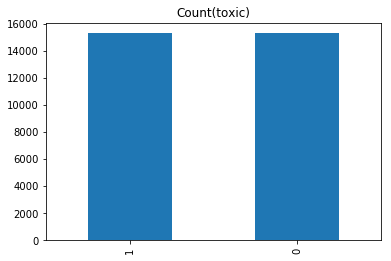

In [17]:
train_under.toxic.value_counts().plot(kind='bar', title='Count(toxic)')

In [18]:
train_under.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean_comment_text
106022,3735c95df054e37a,"""\nIs the word """"must"""" or """"should""""? I have ...",0,0,0,0,0,0,""" Is word "" "" must "" "" "" "" "" "" ? I problem exp..."
155987,c6f930741241c48a,"""\n\n SPANIARDS ARE NOT WHITE?? OH LORD \n\n ...",0,0,0,0,0,0,""" SPANIARDS ARE NOT WHITE ? ? OH LORD 51 % eur..."
72668,c26def64cf350efc,"""\n\nIt makes sense, but it seems so backwards...",0,0,0,0,0,0,""" It make sense , seem backwards . If you are ..."
143783,02ad290bc68b3659,"""\n\n September 2010 \n\n Please do not vandal...",0,0,0,0,0,0,""" September 2010 Please vandalize page , edit ..."
144152,089851d6351e67ad,"""\n\nI have a feeling that proposal would be c...",0,0,0,0,0,0,""" I feel proposal would contest , Izmir well-k..."


### Tomek links

In [19]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.under_sampling import TomekLinks

In [20]:
f_values = train[["severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [21]:
t_values = train['toxic'].values

In [22]:
tl = TomekLinks(return_indices=True, ratio='majority')
fv_tl, tv_tl, id_tl = tl.fit_sample(f_values, t_values)

In [23]:
print(len(id_tl))

159571


In [24]:
print(len(tv_tl))

159571


### Fill NA

In [19]:
list_sentences_train = train_under["comment_text"].fillna("_na_").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_under[list_classes].values
list_sentences_test = test["comment_text"].fillna("_na_").values

### Tokenize

In [20]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [21]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE))

In [22]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.020940498, 0.6441043)

### Embedding and Build model

In [23]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [24]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model.fit(X_t, y, batch_size=32, epochs=6, validation_split=0.1)

Train on 27529 samples, validate on 3059 samples
Epoch 1/6
27529/27529 [==============================] - 166s 6ms/step - loss: 0.2144 - acc: 0.9133 - val_loss: 0.3327 - val_acc: 0.8606
Epoch 2/6
27529/27529 [==============================] - 155s 6ms/step - loss: 0.1580 - acc: 0.9358 - val_loss: 0.2946 - val_acc: 0.8744
Epoch 3/6
27529/27529 [==============================] - 171s 6ms/step - loss: 0.1408 - acc: 0.9426 - val_loss: 0.2847 - val_acc: 0.8806
Epoch 4/6
27529/27529 [==============================] - 182s 7ms/step - loss: 0.1282 - acc: 0.9470 - val_loss: 0.2715 - val_acc: 0.8840
Epoch 5/6
27529/27529 [==============================] - 178s 6ms/step - loss: 0.1183 - acc: 0.9511 - val_loss: 0.2745 - val_acc: 0.8859
Epoch 6/6
27529/27529 [==============================] - 171s 6ms/step - loss: 0.1084 - acc: 0.9551 - val_loss: 0.2799 - val_acc: 0.8855


In [26]:
y_test = model.predict([X_te], batch_size=1024, verbose=1)
sample_submission = pd.read_csv(f'{path}sample_submission.csv')
sample_submission[list_classes] = y_test
sample_submission.to_csv(f'{path}submission_rc_rus.csv', index=False)

153164/153164 [==============================] - 99s 647us/step
